### CITS5508 labsheet 5

**Name: Wei Yang**<br>
**Student number: 21220208**<br>
**Date created:  4th May 2021**<br>
**Last modified: 22th May 2021**<br>

## 1. Introduction
This labsheet is to train an MLP and a CNN for the classification task and compare their performance. This lab sheet consists of a large project using the CIFAR-10 dataset. This is a data set containing 10 classes of 32 × 32 colour images. The training set is perfectly balanced, with 6,000 images per class.
The test set contains 10,000 instances.

In [1]:
#import library
import os
import sys
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from data_loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
sys.path.append(os.getcwd()) 

## 2: Data preparation and visualisation
### 2.1 Data loading

In [2]:
# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

In [3]:
# A quick inspection of the outputs from the `load_batch` function
# You need to split the training set to form a validation set. The original
# training set would become smaller.
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


### 2.2 Data spliting

In [4]:
#Splitting for training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

### 2.3 Display randomly images

In [5]:
#Define a function to plot 20 radomly sampled images
def plot_sample_images(X,y, title,rows=4, cols=5, figsize=(14,8)):
    '''
    function to plot 20 radomly sampled images
    '''
    images = np.random.choice(len(X)-1, size=20, replace=False, p=None)
    plt.figure(figsize=figsize)
    j=1
    for i in images:
        image = X[i]
        ax = plt.subplot(rows,cols,j)
        j+=1
        plt.imshow(image)
        plt.axis('off')
        ax.set_title(f"{class_names[y[i]]}")
    plt.suptitle("20 randomly images for "+title,fontsize=20, color = 'red')
    plt.show()
    
    

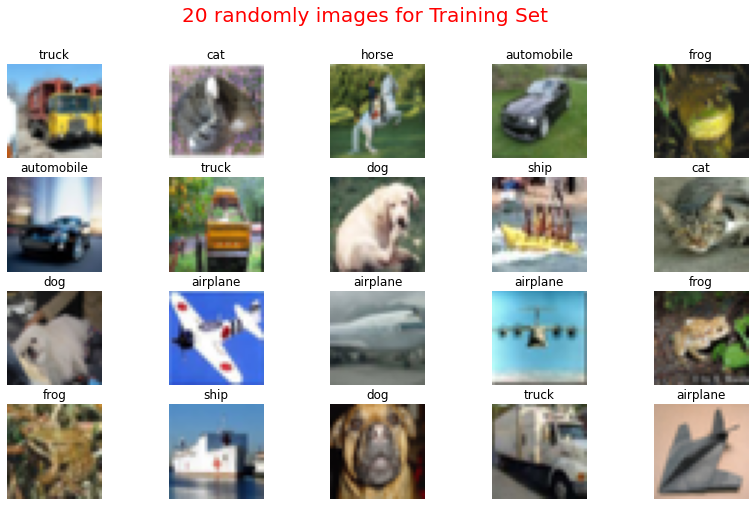

In [6]:
#Display 20 images for the training set
plot_sample_images(X=X_train,y=y_train,title="Training Set")

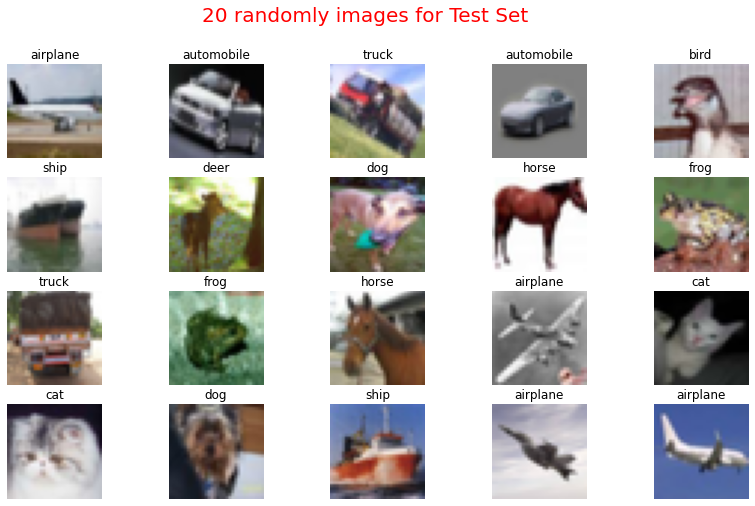

In [7]:
#Display 20 images for the test set
plot_sample_images(X=X_test,y=y_test,title="Test Set")

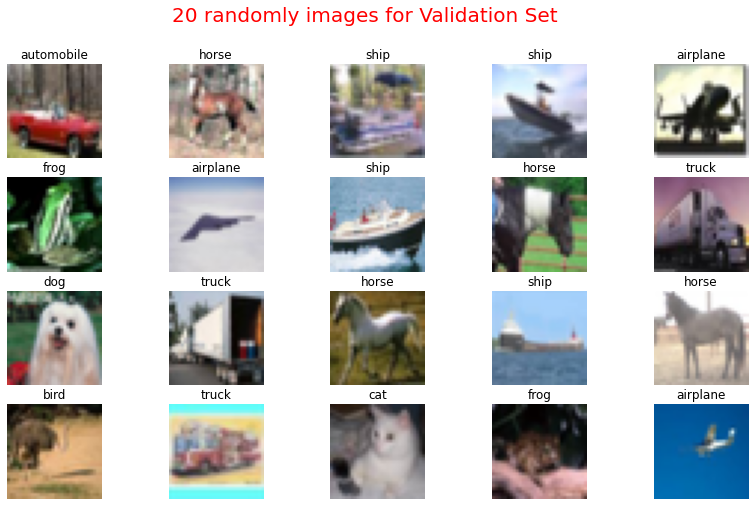

In [8]:
#Display 20 images for the validation set
plot_sample_images(X=X_val,y=y_val,title="Validation Set")

##  3. Implementation of an MLP
### 3.1 Hyperparameters
**In order to do the hyperparameter tuning process, the first step is to create a function that will build and compile a Keras model. Then, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. I use a 2  hiden layers modle and the input of the function are list below:**

- number of layer: I set it to be 2 in our case
- n_neurons1: the number or nueurons for the first hiden layer. I choose it to be 512.
- n_neurons2: the number or nueurons for the second hiden layer. I choose it to be 128.
- act1: the activation function for hiden layer. I choosed e 'relu'.
- act2: the activation function for output layer. I choosed e 'relu'.
- kernel_initializer1: connection weight initialisation for the hiden layer.(need to be determined)
- kernel_initializer2: connection weight initialisation for the output layer.(need to be determined)
- rate: dropout rate-probability p of being temporarily dropped out. (need to be determined)
- scheduling: Learning Rate Scheduling.(need to be determined)


**Connection weight initialisation**
In order to deal with vanishing gradients problem, the connection weight initialisation is introduced.We don’t want the signal to die out, nor do we want it to explode and saturate.The two connection weights tested were 
- Glorot initialization 
- He Initialization. 

The fine turning result shows it is better to use He Initialization at hiden layer and to use Glorot initialization at outcome layer

**Learning rate scheduling**

Finding a good learning rate can be tricky.
- If we set it way too high, training may actually diverge
- If we set it too low, training will eventually converge to the optimum, but it will take a very long time.
- If we set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never really settling down.

The two learning rate sheduling I am going to choose from are:<br>
- Exponential scheduling:
Set the learning rate to: η(t) = η0 0.1t/s. The learning rate will gradually drop by a
factor of 10 every s steps.<br>
Learning rate functions for Exponential scheduling:
<pre>
def exponential(epoch):      
     return 0.01 * 0.1**(epoch / 20)
</pre><br>

- Piecewise constant scheduling:
Use a constant learning rate for a number of epochs, then a smaller learning rate for another number of epochs. <br>
Learning rate functions for Piecewise constant scheduling:
<pre>
 def piecewise(epoch):
      if epoch < 5:
         return 0.01
      elif epoch < 15:
         return 0.005
      else:
         return 0.001
</pre>

Use lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise/exponential) as parameter for callback.<br><br>
Since it need through callback, so it can not be done by GridSearchCV. I just set up two function for each learning scheduling and use both to calculate the accuracy for validation set and compare the result. It shows Exponential scheduling tend to has better result.


**Dropout rate**<br>
Dropout is one of the most popular regularization techniques for deep neural networks. At every training step, every neuron has a probability p of being temporarily dropped out. The hyperparameter p is dropout rate. After training, neurons don’t get dropped anymore.If you observe that the model is overfitting, you can increase the dropout rate. Conversely,you should try decreasing the dropout rate if the model underfits the training set.<br>
The two options for dropout rate are: 
- 0.5 
- 0.1<br>

The fine turning result shows setting the rate to be 0.1 is better in our case. It gives a better accuracy without  overfit.

**Early stopping**<br>
Early stopping was implemented using validation loss with a patience of 3. Training will stop after 100 epochs with no decrease in the validation loss. With the hyperparameter we set, the training tend to stop at about 30th epochs.

**The fine turning code is shown in the following block and has been comment out.**


In [9]:
# def exponential(epoch):
#      return 0.01 * 0.1**(epoch / 20)
    
# def piecewise(epoch):
#      if epoch < 5:
#         return 0.01
#      elif epoch < 15:
#         return 0.005
#      else:
#         return 0.001

# def build_model(n_neurons1=512, n_neurons2=128, act1='relu',act2="softmax",rate = 0.2, kernel_initializer1='he_normal',kernel_initializer2="glorot_uniform"): 
#     model = keras.models.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(32, 32, 3))),
#     keras.layers.Dropout(rate=rate),   
#     model.add(keras.layers.Dense(n_neurons1, activation=act1,kernel_initializer=kernel_initializer1))
#     keras.layers.Dropout(rate=rate),
#     model.add(keras.layers.Dense(n_neurons2, activation=act1,kernel_initializer=kernel_initializer1))
#     keras.layers.Dropout(rate=rate),
#     model.add(keras.layers.Dense(10, activation=act2,kernel_initializer=kernel_initializer2))
#     model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd',metrics=["accuracy"])
#     return model

# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

# parameter_space = {
#       "kernel_initializer1": ['he_normal', 'glorot_uniform'],
#       "kernel_initializer2": ['he_normal', 'glorot_uniform'],
#       "rate": [0.1, 0.5]
# }

# lr_scheduler = keras.callbacks.LearningRateScheduler(exponential)
# clf = GridSearchCV(keras_reg, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train, epochs=100,
# validation_data=(X_val, y_val),
# callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True),lr_scheduler])

# print(clf.best_params_)

### 3.2 Architecture,Training and Testing


In [10]:
#set up the model and display its architecture
mlp_model = keras.Sequential([
    # the first layer of neural network
    keras.layers.Flatten(input_shape=(32, 32, 3)),
    keras.layers.Dropout(rate=0.1),
    # the first hidden layer
    keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.1),
    # the second hidden layer
    keras.layers.Dense(128, activation='relu',kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.1),
    # output layer
    keras.layers.Dense(10, activation='softmax',kernel_initializer="glorot_uniform")
])

#Sgd optimizer is used and sparse_categorical_crossentropy is used as our loss function
mlp_model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

#display its architecture
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

- There are totally 7 layers which include an input layer,2 hiden layer, 3 dropout layer and an output layer.
- There are totally 1,640,330 parameters and all of them are trainalbe.

### 3.2 Training and Testing

In [11]:
#Define the learning rate scheduling function we are going to use
def exponential(epoch):
     return 0.01 * 0.1**(epoch / 20)
    
#if the MLP model subdirectory is present in the current directory
if os.path.exists('Yang_Wei-MLP'):
    #load the model
    mlp_model = keras.models.load_model("Yang_Wei-MLP.")  
    #display its architecture
    mlp_model.summary()
    #train for one epoch
    mlp_model.fit(X_train,y_train,epochs=1,verbose=0)
#if the MLP model subdirectory is not present in the current directory
else:
    #train the model from scratch for 100 epochs using the optimal hyperparamter values
    lr_scheduler = keras.callbacks.LearningRateScheduler(exponential)
    mlp_history = mlp_model.fit(X_train, y_train, epochs=100,validation_data=(X_val, y_val), verbose=1, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),lr_scheduler])
    #save the model
    mlp_model.save("Yang_Wei-MLP.")    

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9570 - accuracy: 0.2913 - val_loss: 1.7773 - val_accuracy: 0.3640
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7948 - accuracy: 0.3584 - val_loss: 1.7113 - val_accuracy: 0.3879
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7256 - accuracy: 0.3827 - val_loss: 1.6498 - val_accuracy: 0.4164
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6809 - accuracy: 0.4028 - val_loss: 1.6348 - val_accuracy: 0.4142
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6498 - accuracy: 0.4135 - val_loss: 1.5979 - val_accuracy: 0.4251
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6203 - accuracy: 0.4246 - val_loss: 1.5794 - val_accuracy: 0.4429
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 1.6011 - accuracy: 0.4313 - val_loss: 1.5572 - val_ac

In [12]:
#test the model on the test set.
y_pred_mlp_test = mlp_model.predict_classes(X_test)
#test the model on the training set.
y_pred_mlp_train = mlp_model.predict_classes(X_train)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [13]:
#print the accuracy of training and testing set
print('\033[1;31m' + f"Accuracy of MLP model:\033[0m \n Training set: {accuracy_score(y_train,y_pred_mlp_train)} \n Testing set:: {accuracy_score(y_test,y_pred_mlp_test)}")

Accuracy of MLP model: 
 Training set: 0.519875 
 Testing set:: 0.488


We can see that the accuracy of training set is slightly higher than the result of testing set. It indicates our model is neither overfit nor underfit.

### 3.3 Classification results
#### 3.3.1 Confusion Matrix

In [89]:
#Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, display_labels=class_names,xticks_rotation='vertical',cmap=plt.cm.Blues,title="hello"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    fig, ax = plt.subplots(1, figsize=(12,10))
    plt.suptitle(title,fontsize=30, color = 'red')
    disp.plot(cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

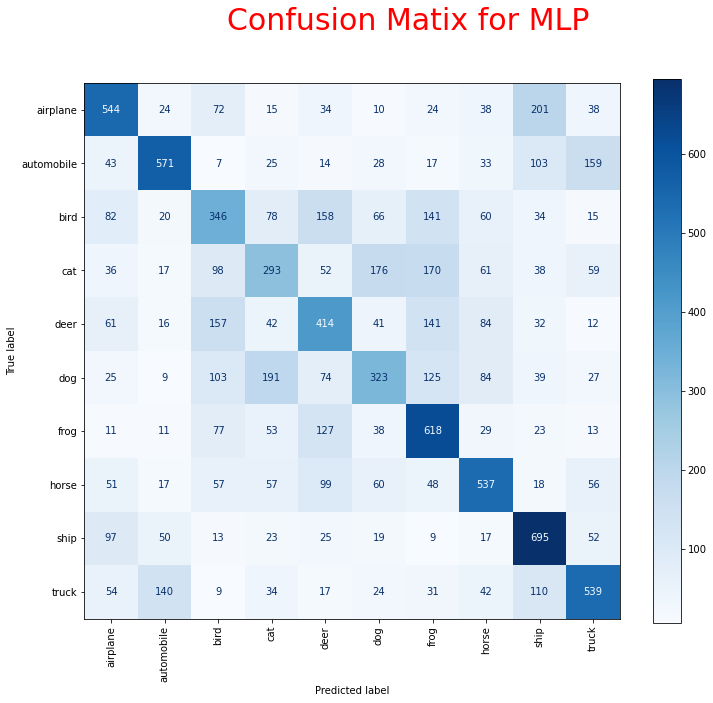

In [90]:
#Plot the confusion matrix for MLP
plot_confusion_matrix(y_test, y_pred_mlp_test,title="Confusion Matix for MLP")

#### 3.3.2 Accuracy and F1 score

In [16]:
#Shows the summary of the result with accuracy and f1 score
print(classification_report(y_test, y_pred_mlp_test, digits=3))

              precision    recall  f1-score   support

           0      0.542     0.544     0.543      1000
           1      0.653     0.571     0.609      1000
           2      0.368     0.346     0.357      1000
           3      0.361     0.293     0.324      1000
           4      0.408     0.414     0.411      1000
           5      0.411     0.323     0.362      1000
           6      0.467     0.618     0.532      1000
           7      0.545     0.537     0.541      1000
           8      0.538     0.695     0.606      1000
           9      0.556     0.539     0.547      1000

    accuracy                          0.488     10000
   macro avg      0.485     0.488     0.483     10000
weighted avg      0.485     0.488     0.483     10000



As we can see from the table:
- the model can achieve a accuracy rount 49% on testing set. 
- The f1 score for each catagory varies between 0.35 and 0.62. The automobile tend to has the best score and it followed by ship. But bird,cat and deer tend to has a lower score.<br>


#### 3.3.3  Correctly images and failure cases 

In [17]:
#Define a function to show a few correctly classified images.
#You can set the rows and cols to print the number of pictures you want
def plot_right_images(title,y_pred, rows=2, cols=5):
    '''
    function to plot right pictures
    '''
    plt.figure(figsize=(14,3.5*rows))
    j=1
    for i in range(len(y_pred)):
        if (j<=cols*rows):
            if (y_pred[i] == y_test[i]):            
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"{class_names[y_pred[i]]}")
        else:
            break
            
    plt.suptitle(title,fontsize=20)
    plt.show()

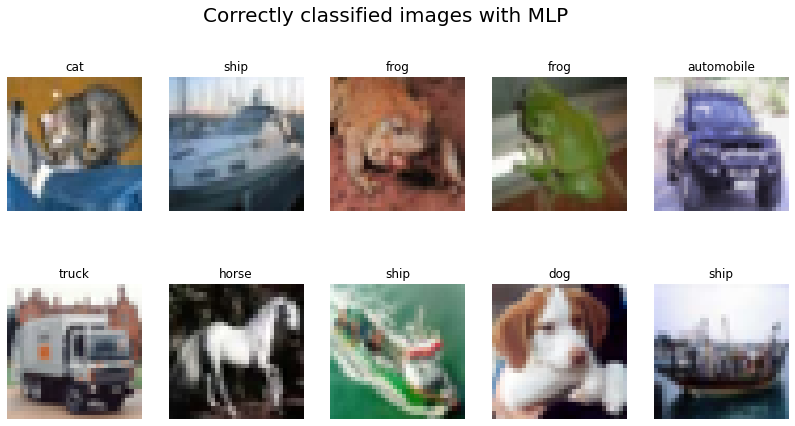

In [18]:
#Plot a few correctly classified images
plot_right_images(title="Correctly classified images with MLP",y_pred=y_pred_mlp_test)

In [19]:
#Define a function to show a few wrongly classified images.
#You can set the rows and cols to print the number of pictures you want
def plot_wrong_images(title,y_pred,rows=2, cols=5):
    '''
    function to plot right pictures
    '''
    plt.figure(figsize=(14,3.5*rows))
    j=1
    for i in range(len(y_pred)):
        if (j<=cols*rows):
            if (y_pred[i] != y_test[i]):            
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"{class_names[y_test[i]]} not {class_names[y_pred[i]]}", color = 'red')
                
        else:
            break
            
    plt.suptitle(title,fontsize=20)
    plt.show()

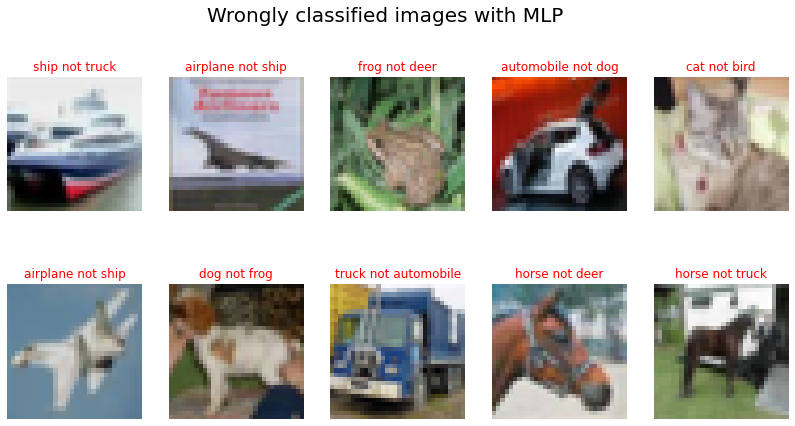

In [20]:
#Plot a few wrongly classified images
#The title of each image are in red color shows they are wrongly predicted.
#It is in the format of [TRUE CLASS] NOT [PREDICTED CLASS]
plot_wrong_images(title="Wrongly classified images with MLP",y_pred=y_pred_mlp_test)

##  4. Implementation of an CNN
### 4.1 Hyperparameters

In order to do the hyperparameter tuning process, the first step is to create a function that will build and compile a Keras model. Then, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors. I use a 2  convolutional layers modle. For your CNN, I use the optimal way to initialise the network, the optimal learning rate, scheduling, and the optimal dropout value that you found from the training of your MLP model. <br><br>**The Hyperparameters need to choose are list below:**

#### Kernel size
Kernel sizes is the size of the receptive field and I tried 2 different size
- 2 by 2
- 5 by 5

Two size has been tested, 2 by 2 tend to have a better accuracy but it has the problme of overfit. The accuracy of training set was over 86% but the result of the test set is similar as 5 by 5 at around 70%. So the I used 5 by 5 for the model.

#### Number of kernels (filters)
Depend on the task, number of kernels in each layer can change. The more complex the dataset you expect networks with more kernels perform better. Number of kernel at layer layer expected to bigger in the previous layers, as number of possible combination grow. 

In my design, the the second convolutional layer will have twice as many kernels as the first layer
So the test cases inculdes:
- first layer: 32 and Second layer: 64
- first layer: 128 and Second layer: 256

CNNs with two numbers of kernels were tested. Bigger number of kernels tend to have a better accuracy(73% compared with 71%),however it require four times the training time per epoch. Moreover, with 128+256 number of kernels, the accuracy of training set reachs 92% which is much higher than test set. It tend to overfit. So I choosed32+64 kernel size  for two layers to avoid overfit and save training time.


#### Activation function

Two different activation functions were test in the convolutional layers, they are:
- ReLU 
- linear

The model performed better using the ReLU activation function. It reach an accuracy about ten percent higher than with a linear activation function.

**Early stopping**<br>
Early stopping was implemented using validation loss with a patience of 3. Training will stop after 100 epochs with no decrease in the validation loss. With the hyperparameter we set, the training tend to stop at about 40th epochs.

**The fine turning code is shown in the following block and has been comment out.**


In [21]:
# def build_model(num_kernel=64,kernel_size=4,activation='relu'): 
#     model = keras.models.Sequential()
#     model.add(keras.layers.Conv2D(filters=num_kernel, kernel_size=kernel_size, activation=activation,  padding="SAME",input_shape=(32, 32, 3))),
#     model.add(keras.layers.MaxPooling2D(pool_size=2)),
#     model.add(keras.layers.Conv2D(filters=num_kernel*2, kernel_size=kernel_size, activation=activation, padding="SAME", input_shape=(32, 32, 3))),
#     model.add(keras.layers.MaxPooling2D(pool_size=2)),
#     model.add(keras.layers.Flatten()),
#     model.add(keras.layers.Dense(units=128, activation='relu')),
#     model.add(keras.layers.Dropout(0.1)),
#     model.add(keras.layers.Dense(10, activation='linear')),
#     model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd',metrics=["accuracy"])
#     return model
# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# parameter_space = {
#        "num_kernel": [64, 128]
#        "kernel_size": [2, 4]
#        "kernel_size": ['relu', 'linear']
# }
# clf = GridSearchCV(keras_reg, parameter_space, n_jobs=-1, cv=3)
# clf.fit(X_train, y_train, epochs=100,
# validation_data=(X_val, y_val), verbose=1,
# callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True),lr_scheduler])
# print(clf.best_params_)


### 4.2 Architecture

In [78]:
#Set up the CNN model
cnn_model = keras.Sequential([
    # the first convolutional layer of neural network
    keras.layers.Conv2D(32, 5, activation='relu',padding="SAME",input_shape=(32, 32, 3)),
    # the first pooling layer of neural network
    keras.layers.MaxPool2D(2),
    # the second convolutional layer of neural network
    keras.layers.Conv2D(64, 5, activation='relu',padding="SAME", input_shape=(32, 32, 3)),
    # the second pooling layer of neural network
    keras.layers.MaxPool2D(2),
    #input layer
    keras.layers.Flatten(),
    # Droplout layer
    keras.layers.Dropout(0.1),
    # BatchNormalization layer
    keras.layers.BatchNormalization(),
    # output layer
    keras.layers.Dense(10, activation='softmax')
    ])

#Sgd optimizer is used and sparse_categorical_crossentropy is used as our loss function
cnn_model.compile(loss="sparse_categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

#display its architecture
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)             

- There are totally 8 layers which include 2 convolutional layer,2 pooling layer, an input layer, a dropout layer, a batch_nomalization layer and an output layer.
- There are totally 111,050 parameters and 102,858 trainalbe parameters.

### 4.3 Training and testing

In [79]:
#if the MLP model subdirectory is present in the current directory
if os.path.exists('Yang_Wei-CNN'):
    #load the model
    cnn_model = keras.models.load_model("Yang_Wei-CNN.") 
    #display its architecture
    cnn_model.summary()
    #train for one epoch
    cnn_model.fit(X_train,y_train,epochs=1,verbose=0)
#if the MLP model subdirectory is not present in the current directory
else:
    #train the model from scratch for 100 epochs using the optimal hyperparamter values
    cnn_history = cnn_model.fit(X_train, y_train, epochs=100,validation_data=(X_val, y_val), verbose=1, callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),lr_scheduler])
    #save the model
    cnn_model.save("Yang_Wei-CNN.")    

Epoch 1/100
1250/1250 [==============================] - 23s 19ms/step - loss: 1.5630 - accuracy: 0.4497 - val_loss: 1.7060 - val_accuracy: 0.4332
Epoch 2/100
1250/1250 [==============================] - 23s 19ms/step - loss: 1.2022 - accuracy: 0.5786 - val_loss: 1.3441 - val_accuracy: 0.5389
Epoch 3/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.0639 - accuracy: 0.6306 - val_loss: 1.1345 - val_accuracy: 0.6067
Epoch 4/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9682 - accuracy: 0.6632 - val_loss: 1.0393 - val_accuracy: 0.6402
Epoch 5/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9052 - accuracy: 0.6847 - val_loss: 1.0209 - val_accuracy: 0.6517
Epoch 6/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.8575 - accuracy: 0.7035 - val_loss: 0.9440 - val_accuracy: 0.6779
Epoch 7/100
1250/1250 [==============================] - 23s 18ms/step - loss: 0.8127 - accuracy: 0.7199 - val_loss: 1

In [83]:
#test the model on the test set.
y_pred_cnn_test = cnn_model.predict_classes(X_test)
#test the model on the training set.
y_pred_cnn_train = cnn_model.predict_classes(X_train)

In [84]:
#print the accuracy of training and testing set
print('\033[1;31m' + f"Accuracy of CNN model:\033[0m \n Training set: {accuracy_score(y_train,y_pred_cnn_train)} \n Testing set:: {accuracy_score(y_test,y_pred_cnn_test)}")

Accuracy of CNN model: 
 Training set: 0.77905 
 Testing set:: 0.6946


We can see that the accuracy of training set is slightly higher than the result of testing set. It indicates our model is neither overfit nor underfit.

### 4.4 Classification results
#### 4.4.1 Confusion Matrix

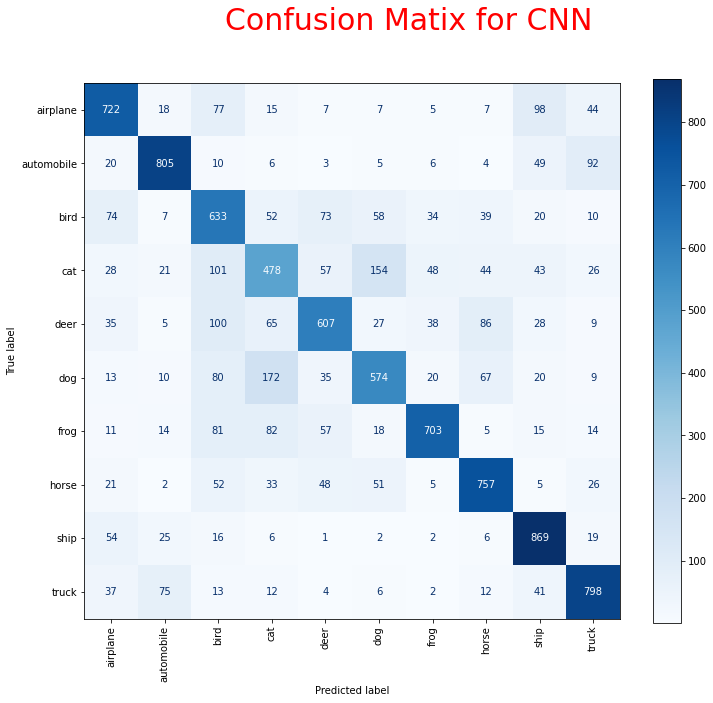

In [91]:
#Plot the confusion matrix for MLP
plot_confusion_matrix(y_test, y_pred_cnn_test,title="Confusion Matix for CNN")

#### 4.4.2 Accuracy and F1 score

In [92]:
#Shows the summary of the result with accuracy and f1 score
print(classification_report(y_test, y_pred_cnn_test, digits=3))

              precision    recall  f1-score   support

           0      0.711     0.722     0.717      1000
           1      0.820     0.805     0.812      1000
           2      0.544     0.633     0.585      1000
           3      0.519     0.478     0.498      1000
           4      0.680     0.607     0.642      1000
           5      0.636     0.574     0.604      1000
           6      0.815     0.703     0.755      1000
           7      0.737     0.757     0.747      1000
           8      0.731     0.869     0.794      1000
           9      0.762     0.798     0.780      1000

    accuracy                          0.695     10000
   macro avg      0.696     0.695     0.693     10000
weighted avg      0.696     0.695     0.693     10000



As we can see from the table:
- the model can achieve a accuracy rount 70% on testing set. 
- The f1 score for each catagory varies between 0.585 and 0.812. The automobile tend to has the best score and it followed by ship. But bird,cat tend to has a lower score.<br>

#### 4.4.3  Correctly images and failure cases 

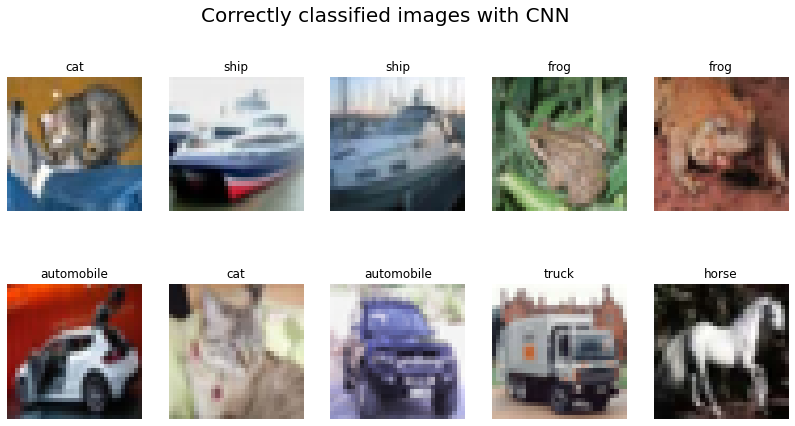

In [93]:
#Plot a few correctly classified images
plot_right_images(title="Correctly classified images with CNN",y_pred=y_pred_cnn_test)

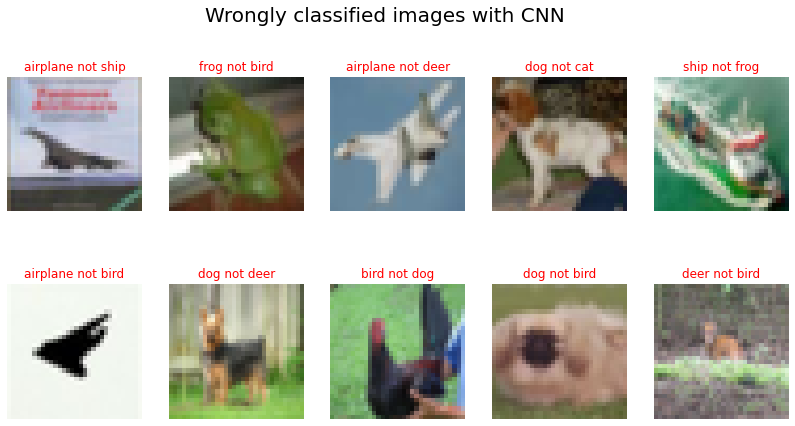

In [94]:
#Plot a few wrongly classified images
#The title of each image are in red color shows they are wrongly predicted.
#It is in the format of [TRUE CLASS] NOT [PREDICTED CLASS]
plot_wrong_images(title="Wrongly classified images with CNN",y_pred=y_pred_cnn_test)

## 5. Comparison & Summary

### 5.1 Classification accuracies

In [95]:
#print the accuracy for MLP
print('\033[1;31m' + f"Accuracy of CNN model:\033[0m \n Training set: {accuracy_score(y_train,y_pred_cnn_train)} \n Testing set:: {accuracy_score(y_test,y_pred_cnn_test)}")
#print the accuracy of training and testing set
print('\033[1;31m' + f"Accuracy of MLP model:\033[0m \n Training set: {accuracy_score(y_train,y_pred_mlp_train)} \n Testing set:: {accuracy_score(y_test,y_pred_mlp_test)}")

Accuracy of CNN model: 
 Training set: 0.77905 
 Testing set:: 0.6946
Accuracy of MLP model: 
 Training set: 0.519875 
 Testing set:: 0.488


As we can see, the CNN model tend to have a higher accuracy compared with MLP model. The MPL reaches a prediction accuracy of around 49%, while the convolutional neural network's accuracy is about 70%. 

### 5.2 Confusion matrices

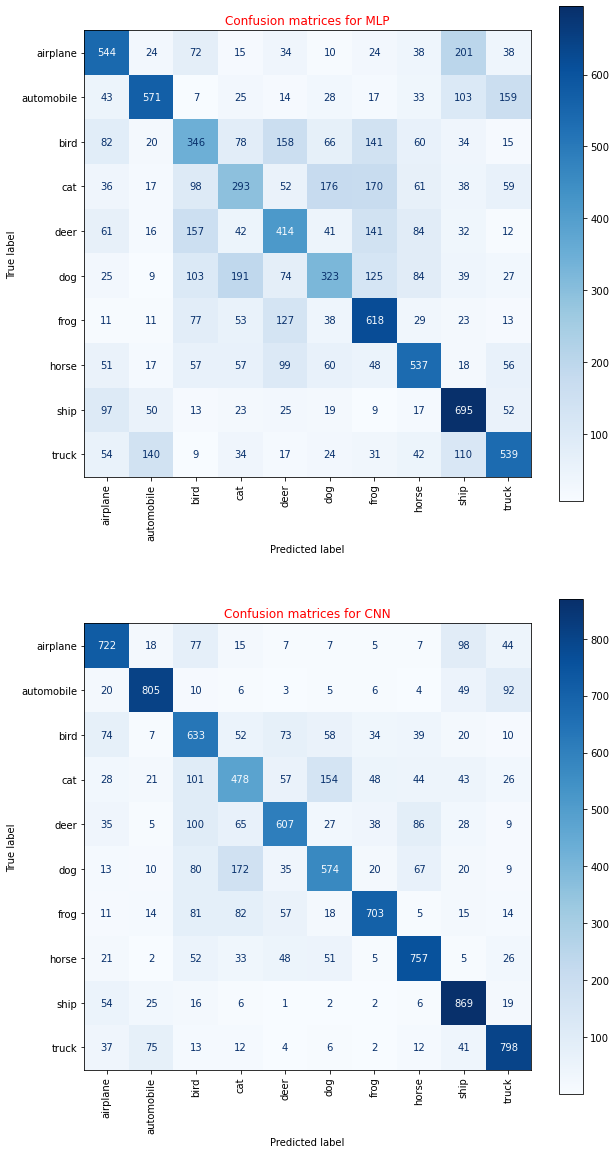

In [96]:
def plot_confusion_matrix(y_true, mlp_y_pred, cnn_y_pred, display_labels=class_names,xticks_rotation='vertical',cmap=plt.cm.Blues):
    fig, ax = plt.subplots(nrows=2, figsize=(10,20))
    mlp_cm = confusion_matrix(y_true, mlp_y_pred)
    mlp_disp = ConfusionMatrixDisplay(confusion_matrix=mlp_cm, display_labels=display_labels)
    mlp_disp.plot(cmap=cmap, ax=ax[0], xticks_rotation=xticks_rotation)
    ax[0].set_title("Confusion matrices for MLP", color = 'red')
    cnn_cm = confusion_matrix(y_true, cnn_y_pred)
    cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=display_labels)
    cnn_disp.plot(cmap=cmap, ax=ax[1], xticks_rotation=xticks_rotation)
    ax[1].set_title("Confusion matrices for CNN", color = 'red')
plot_confusion_matrix(y_test, y_pred_mlp_test, y_pred_cnn_test)

### 5.3 Network architectures
The summaries of the architectures of both networks are shown below. 

It is shown than the MLP network has fewer layers and less perceptrons than the CNN. However, MLP also has more trainable parameters because each layer is fully connected. 

The CNN is a deeper network which has more types of layers. But it has fewer trainable parameters due to the receptive field.



In [97]:
#MLP model architectures
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [98]:
#CNN model architectures
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)             

### 5.4 Training time
It takes 4-5 times longer to train a CNN than to train a MLP for each epoch. This is because it need to scan every image with 3 chanels using a large number of filters. It makes (images * chanels * num_filters) feature maps for each convolutional layer.  However,training MLP usually takes about 40 epochs. CNN only take about 10-20 epochs to early stop. 


### 5.4 Example images
#### 5.4.1 One model worked but the other failed

In [142]:
#Define a function to show a few example of one model worked but the other failed.
def plot_one_images(title,y_pred_CNN , y_pred_MLP, rows=3, cols=3):
    '''
    function to plot right pictures
    '''
    plt.figure(figsize=(14,3.5*rows))
    j=1
    for i in range(len(y_test)):
        if (j<=cols*rows):
            if (y_pred_CNN[i] != y_test[i] and y_pred_MLP[i] == y_test[i]):            
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"MLP Right: {class_names[y_pred_MLP[i]]} || CNN: {class_names[y_pred_CNN[i]]}")
            elif (y_pred_CNN[i] == y_test[i] and y_pred_MLP[i] != y_test[i]):
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"CNN Right: {class_names[y_pred_CNN[i]]} || MLP: {class_names[y_pred_MLP[i]]}")
        else:
            break
            
    plt.suptitle(title,fontsize=20)
    plt.show()

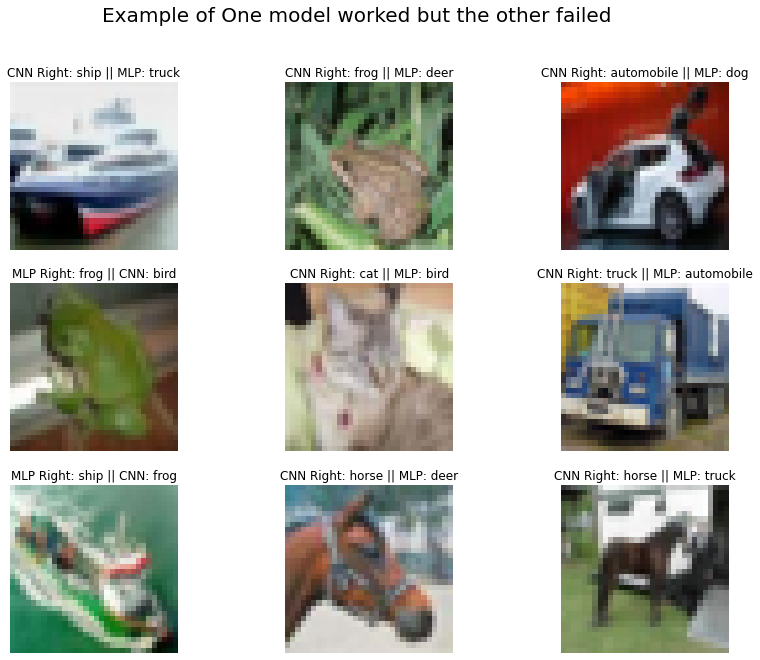

In [147]:
#The format is right class||wrong class
plot_one_images(title="Example of One model worked but the other failed",y_pred_CNN=y_pred_cnn_test,y_pred_MLP=y_pred_mlp_test)

#### 5.4.2 Classes where both worked well


In [148]:
def plot_both_images(title,y_pred_CNN , y_pred_MLP, rows=3, cols=3):
    '''
    function to plot right pictures
    '''
    plt.figure(figsize=(14,3.5*rows))
    j=1
    for i in range(len(y_test)):
        if (j<=cols*rows):
            if (y_pred_CNN[i] == y_test[i] and y_pred_MLP[i] == y_test[i]):            
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"Both Right: {class_names[y_pred_MLP[i]]}")
        else:
            break
            
    plt.suptitle(title,fontsize=20)
    plt.show()

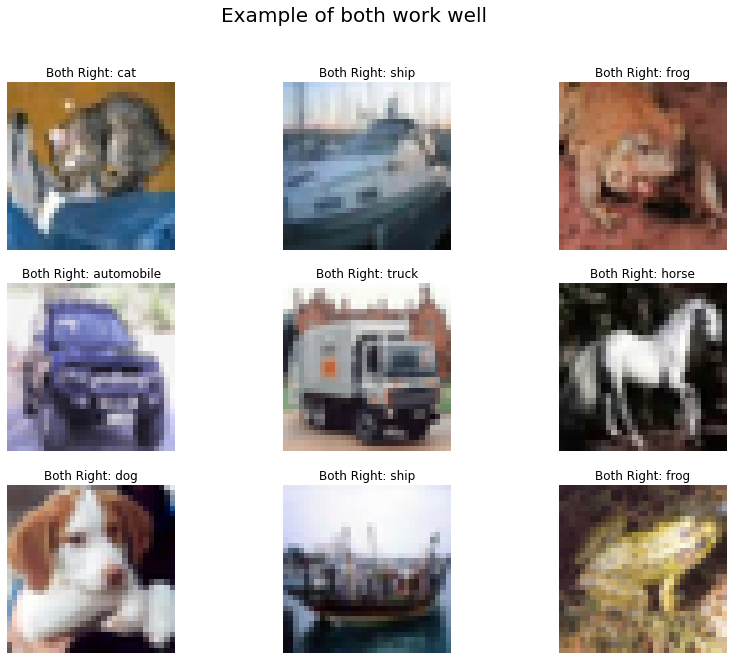

In [149]:
#Show both right images
plot_both_images(title="Example of both work well",y_pred_CNN=y_pred_cnn_test,y_pred_MLP=y_pred_mlp_test)

#### 5.4.3 Classes where both failed

In [161]:
#Define a function to show a few example of one model worked but the other failed.
def plot_none_images(title,y_pred_CNN , y_pred_MLP, rows=3, cols=3):
    
    plt.figure(figsize=(14,3.5*rows))
    j=1
    for i in range(len(y_test)):
        if (j<=cols*rows):
            if (y_pred_CNN[i] != y_test[i] and y_pred_MLP[i] != y_test[i]):            
                image = X_test[i]
                ax = plt.subplot(rows,cols,j)
                j+=1
                plt.imshow(image)
                plt.axis('off')
                ax.set_title(f"{class_names[y_test[i]]} || MLP: {class_names[y_pred_MLP[i]]} || CNN: {class_names[y_pred_CNN[i]]}")
         
        else:
            break
            
    plt.suptitle(title,fontsize=20)
    plt.show()

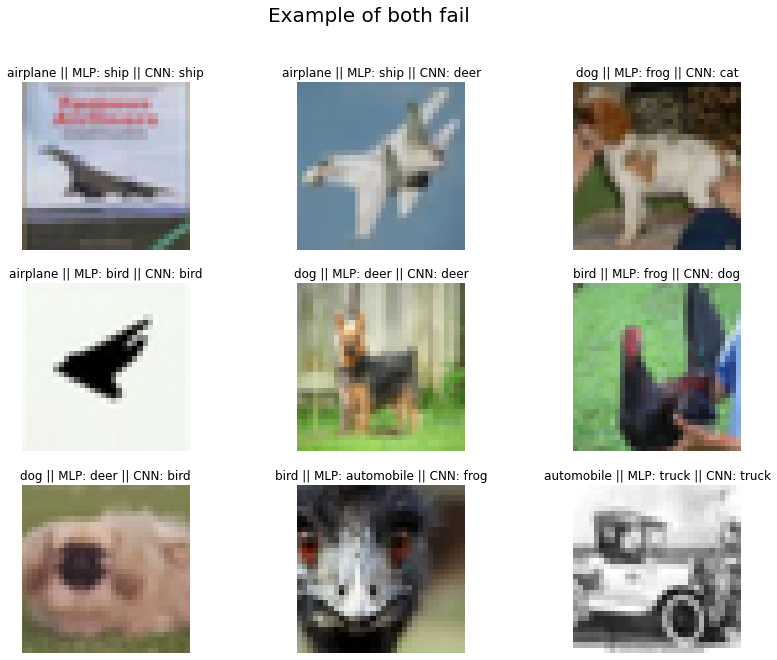

In [162]:
#The first is right class and followed by MLP and CNN prediction
plot_none_images(title="Example of both fail",y_pred_CNN=y_pred_cnn_test,y_pred_MLP=y_pred_mlp_test)